# Examining the Gordon prescription

In [9]:
# imports

from importlib import reload

import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from datetime import datetime, time
import random 

import pandas
import seaborn as sns

from oceancolor.tara import io as tara_io
from oceancolor.ph import pigments
from oceancolor.hydrolight import loisel23
from oceancolor.utils import spectra
from oceancolor.utils import plotting

In [2]:
%matplotlib ipympl

# Load

In [3]:
ds = loisel23.load_ds(4,0)
ds

<xarray.Dataset> Size: 18MB
Dimensions:  (Lambda: 81, IOP_Scenario: 3320)
Coordinates:
  * Lambda   (Lambda) float32 324B 350.0 355.0 360.0 365.0 ... 740.0 745.0 750.0
Dimensions without coordinates: IOP_Scenario
Data variables: (12/17)
    Rrs      (IOP_Scenario, Lambda) float32 1MB 0.01176 0.01201 ... 3.041e-05
    Ed_0+    (IOP_Scenario, Lambda) float32 1MB 0.7753 0.7314 ... 1.237 1.222
    Lw       (IOP_Scenario, Lambda) float32 1MB 0.009118 0.008785 ... 3.716e-05
    Lu_0+    (IOP_Scenario, Lambda) float32 1MB 0.04075 0.03903 ... 0.0624
    a        (IOP_Scenario, Lambda) float32 1MB 0.03096 0.02925 ... 2.83 2.85
    anw      (IOP_Scenario, Lambda) float32 1MB 0.02386 0.02245 ... 0.0004
    ...       ...
    bph      (IOP_Scenario, Lambda) float32 1MB 0.04521 0.04454 ... 0.1008
    bd       (IOP_Scenario, Lambda) float32 1MB 0.03323 0.03239 ... 0.03513
    bb       (IOP_Scenario, Lambda) float32 1MB 0.006968 0.006587 ... 0.001876
    bbnw     (IOP_Scenario, Lambda) float32 1MB 0.00105 0.001028 ... 0.001641
    bbph     (IOP_Scenario, Lambda) float32 1MB 0.0004521 0.0004454 ... 0.001008
    bbd      (IOP_Scenario, Lambda) float32 1MB 0.0005982 0.000583 ... 0.0006324

## Unpack for convenience

In [4]:
wave = ds.Lambda.data
Rrs = ds.Rrs.data
a = ds.a.data
bb = ds.bb.data

# $u$

In [5]:
u = bb / (a+bb)
u.shape

(3320, 81)

# $r_{\rm rs}$

In [21]:
A, B = 0.52, 1.17
rrs = Rrs / (A + B*Rrs)

# Wavelengths

In [17]:
i440 = np.argmin(np.abs(wave-440.))
i500 = np.argmin(np.abs(wave-500.))
i600 = np.argmin(np.abs(wave-600.))

# GIOP

In [20]:
G1, G2 = 0.0949, 0.0794  # Gordon
G1_lee, G2_lee = 0.0949, 0.0794  # Gordon
uval = np.linspace(0., 0.25, 1000)
rrs_GIOP = G1*uval + G2*uval**2
Rrs_GIOP = A*rrs_GIOP / (1 - B*rrs_GIOP)

# Plots

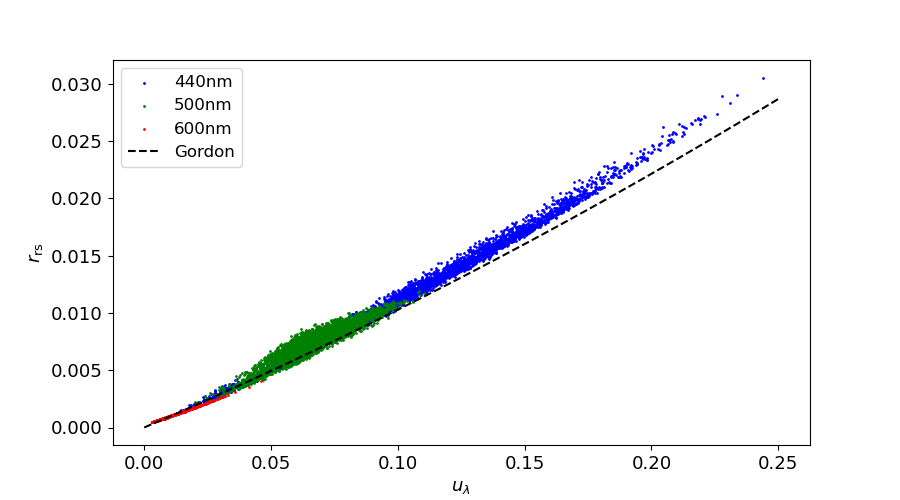

In [22]:
#
fig = plt.figure(figsize=(9,5))

plt.clf()
ax = plt.gca()
ax.scatter(u[:,i440], rrs[:,i440], color='b', s=1., label='440nm')
ax.scatter(u[:,i500], rrs[:,i500], color='g', s=1., label='500nm')
ax.scatter(u[:,i600], rrs[:,i600], color='r', s=1., label='600nm')
# GIOP
ax.plot(uval, rrs_GIOP, 'k--', label='Gordon')
#
ax.set_xlabel(r'$u_\lambda$')
ax.set_ylabel(r'$r_{\rm rs}$')
ax.legend(fontsize=12)
plotting.set_fontsize(ax, 13.)
#
plt.show()